# 3 Random Forest Classification

## Data

### Q3.1 (2 pts)

Consider the possible effects of the clustered sampling design on model calibration and
validation. What are possible effects on the model transferability and general applicability, if the training
data are sampled in a clustered distribution? Will the validation results be rather over or underoptimistic
when the validation points are sampled from the same polygon? Provide a brief assessment in 2 3
sentences for each question

**Answer:** The model is likely to overfit the specific region/cluster/polygon, as it may learn the specific spectra for that (unique) region. So this reduces the transferability and general applicability when it is introduced to samples from outside these clusters (with deviating spectra that were not in the training data). e.g. for water there are three clusters, but sample points near each other might have almost the same spectra.
The validation results will be rather overoptimistic because, as said, if the model overfits on these clusters, giving it samples from these clusters to validate will only reinforce this bias towards the spectra of the cluster. This does not accurately show its performance on more diverse samples (from outside the cluster), where it may perform worse.

## Loading the data

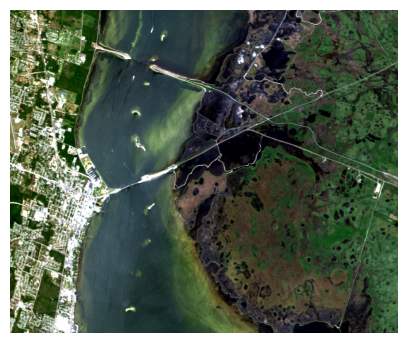

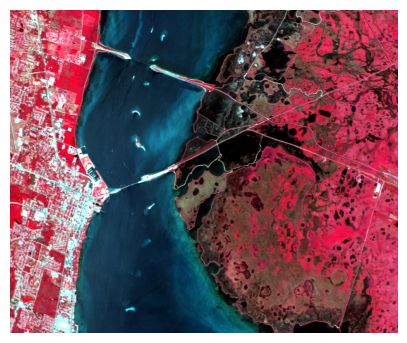

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

path = "C:/Users/louis/Desktop\Hyperspectral Remote Sensing/Sheet03/data"

image_path = f"{path}/aviris_ksc"
image = rasterio.open(image_path)
image_data = image.read()

# this replaces the stretch='lin'
def linear_stretch(band, lower_percent=2, upper_percent=98):
    
    lower = np.percentile(band, lower_percent)
    upper = np.percentile(band, upper_percent)    
    # Clip and scale
    stretched_band = np.clip(band, lower, upper)
    stretched_band = (stretched_band - lower) / (upper - lower)
    return stretched_band

band5 = linear_stretch(image_data[5])     
band15 = linear_stretch(image_data[15])   
band25 = linear_stretch(image_data[25])  
band40 = linear_stretch(image_data[40])

# stacks
rgb = np.dstack((band25, band15, band5))
nir_rg = np.dstack((band40, band25, band15))

plt.figure(figsize=(5, 5))
plt.imshow(rgb)
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(nir_rg)
plt.axis('off')
plt.show()

| 0.00,-0.00, 0.00|
|-0.00,-0.00, 1.00|
| 0.00, 0.00, 1.00|
Shapes [Shape #0: POINT, Shape #1: POINT, Shape #2: POINT, Shape #3: POINT, Shape #4: POINT]
Records [Record #0: [1], Record #1: [1], Record #2: [1], Record #3: [1], Record #4: [1]]


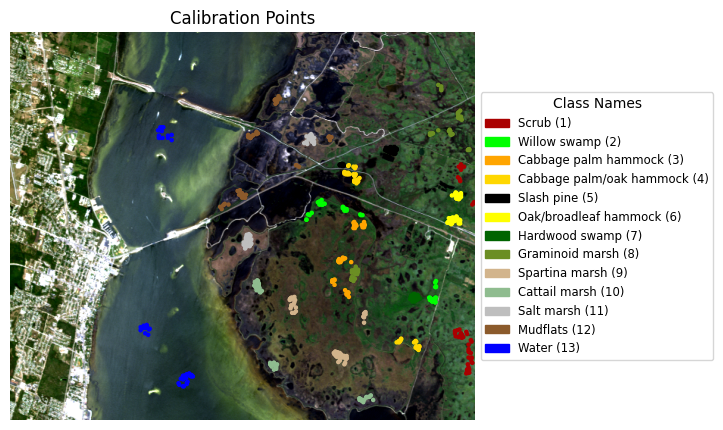

In [ ]:
import shapefile
import pandas as pd
from matplotlib.patches import Patch

wavelengths_df = pd.read_table(f"{path}/aviris_ksc_bands.txt", header=0, sep=" ", decimal=".")
wl = wavelengths_df.iloc[:, 1]

band_names = ['nm' + str(round(w)) for w in wl]

cal_sf = shapefile.Reader(f"{path}/aviris_ksc_gt_calpoints.shp")

transform = image.transform
print(transform)
# coordinates to pixel indices (we need this for the extract fucntion)
def coord_to_pixel(x, y, transform):
    col, row = ~transform * (x, y) #inverse transformation to the pixels of the image
    return int(col), int(row)

# we will need this later for the val points too
def extract(sf):
    sf_shapes = sf.shapes()
    sf_records = sf.records()

    print("Shapes", sf_shapes[:5])
    print("Records", sf_records[:5])

    class_values = [record[0] for record in sf_records]

    # x and y coordinates
    shpx = [shape.points[0][0] for shape in sf_shapes]
    shpy = [shape.points[0][1] for shape in sf_shapes]

    pixel_coords = [coord_to_pixel(x, y, transform) for x, y in zip(shpx, shpy)]
    cols = [col for col, row in pixel_coords]
    rows = [row for col, row in pixel_coords]

    return cols, rows, shpx, shpy, class_values

cal_cols, cal_rows, cal_x, cal_y, cal_class_values = extract(cal_sf)

colors = ['#AA0000', '#00FF00', '#FFA500', '#FFD700', '#000000', '#FFFF00',
          '#006400', '#6B8E23', '#D2B48C', '#8FBC8F', '#BEBEBE', '#8B5A2B',
          '#0000FF']

# dict classes : colors
class_to_color = {cls: colors[i] for i, cls in enumerate(sorted(set(cal_class_values)))}


#show rgb again
plt.figure(figsize=(6, 6))
plt.imshow(rgb)
plt.title('Calibration Points')
plt.axis('off')

# and overlay points + legend
point_colors = [class_to_color[cls] for cls in cal_class_values]
plt.scatter(cal_cols, cal_rows, c=point_colors, s=5)

class_names = [
    "Scrub (1)", "Willow swamp (2)", "Cabbage palm hammock (3)",
    "Cabbage palm/oak hammock (4)", "Slash pine (5)",
    "Oak/broadleaf hammock (6)", "Hardwood swamp (7)",
    "Graminoid marsh (8)", "Spartina marsh (9)",
    "Cattail marsh (10)", "Salt marsh (11)", "Mudflats (12)",
    "Water (13)"
]
legend_handles = [Patch(color=colors[i], label=class_names[i]) for i in range(len(class_names))]

plt.legend(handles=legend_handles, loc='center left', fontsize='small', ncol=1, title="Class Names", bbox_to_anchor=(1, 0.5))

plt.show()

### Q3.2 (1 pt)
Which areas of the image are covered by the ground truth and which are under represented or
not covered at all?

**Answer:** All calibration points are in the easter part (KSC marshlands) except for the *water* class in the Indian River. The western city of Titusville in not covered at all.

In [10]:
points = list(zip(cal_x, cal_y))

# Extract reflectance values 
cal_ref_gen = image.sample(points)
cal_ref = np.array([val for val in cal_ref_gen])

# keeping only valid bands
cal_ref[cal_ref > 65530] = np.nan
valid_bands = ~np.isnan(cal_ref).any(axis=0)
cal_ref = cal_ref[:, valid_bands]
wl_filtered = wl[valid_bands]

## Spectral Library

### Q3.3 (2 pts) 
Try to remember what you have learned about spectra in the last sessions. Do the spectra of
the classes meet your expectation (e.g., do the spectra of a class representing a vegetation type look like a
vegetation spectrum)? Which classes are spectrally heterogeneous (i.e., the spectra vary in shape and
magnitude) and which are homogeneous? With a little experience, this information enables a rough
estimation which classes can be mapped accurately and which not.

**Answer:** The spectral patterns meet my expectations: The vegetation spectra have high reflectance in the NIR (700–1300 nm) and a clear red edge inflection point; classes 1, 3, 4, 5, 6, 7 look almost the same (homogeneous; likely lower accuracy). The others differ in magnitude and shape from each other and are likely easier to map accurately. The marsh classes almost look like dampened vegetation spectra due to their lower reflectance, likely caused by water content or less dense vegetation. Mudflats and water show the lowest reflectance, as expected. 

Willow swamp (2), Graminoid marsh (8), Salt marsh (11), and Mudflats (12) show a high standard deviation in their spectra. The other classes show less variation around their mean (smaller grey areas).


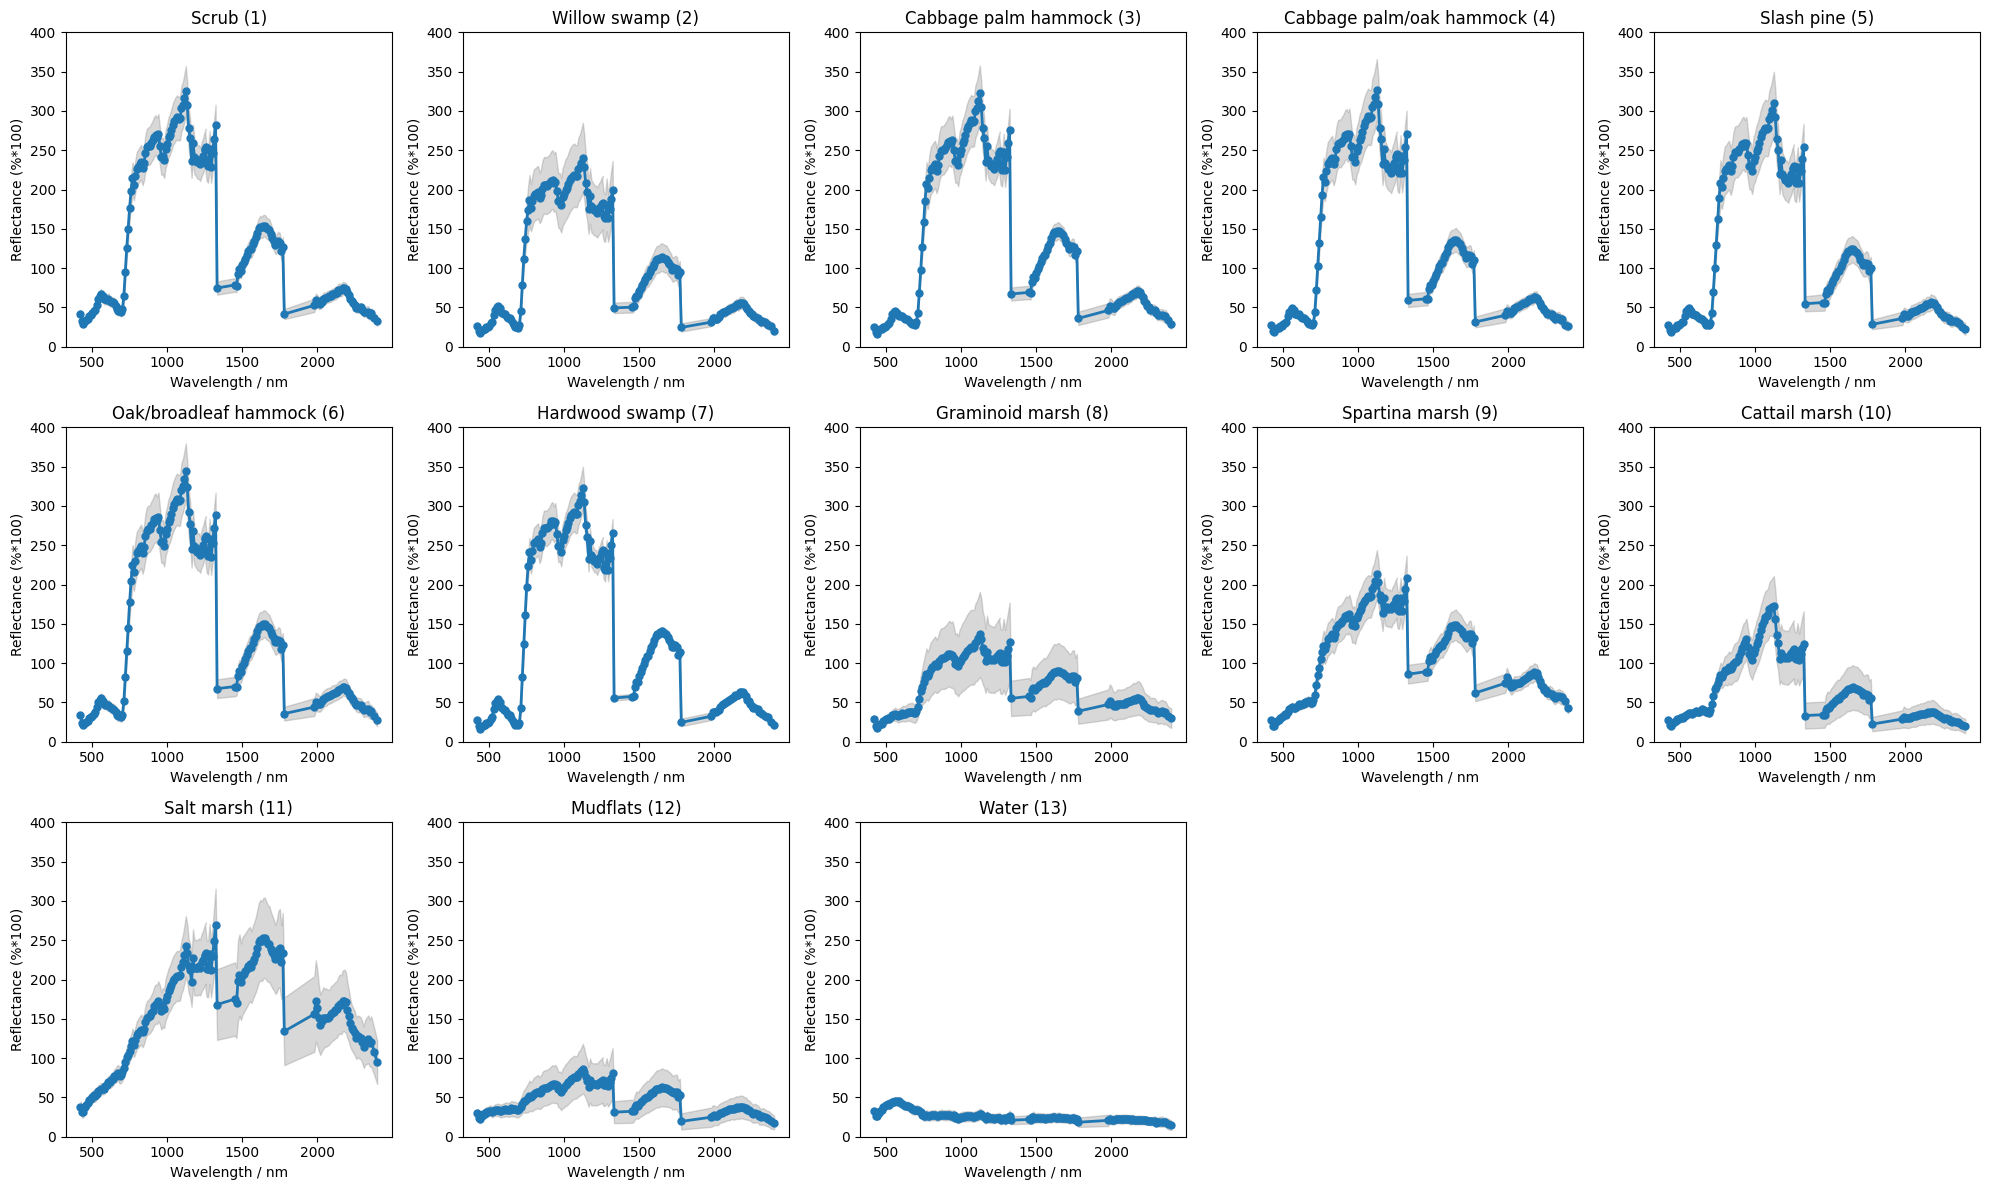

In [11]:

def plot_all_spectras(ref):
    speclib = [ref, wl_filtered]

    def plotspecs(ax, spectra, wl, class_name):
        m = np.nanmean(spectra, axis=0)
        s = np.nanstd(spectra, axis=0)
        ax.plot(wl, m, marker='o', linestyle='-', linewidth=2, markersize=5)
        ax.fill_between(wl, m + s, m - s, color='gray', alpha=0.3)
        ax.set_title(class_name)
        ax.set_xlabel('Wavelength / nm')
        ax.set_ylabel('Reflectance (%*100)')
        ax.set_ylim(0, 400) # same axes for comparison

    fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))
    axes_flat = axes.flatten()

    # plotspec for each class
    unique_classes = np.unique(cal_class_values)
    for i, cls in enumerate(unique_classes):
        # get indices and spectra
        class_indices = [idx for idx, val in enumerate(cal_class_values) if val == cls]
        spectra_class = speclib[0][class_indices, :]

        class_name = class_names[i]
        plotspecs(axes_flat[i], spectra_class, speclib[1], class_name)

    # Hide unused subplots
    for j in range(i + 1, len(axes_flat)):
        axes_flat[j].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_all_spectras(cal_ref)

### Q3.4 (2 pts) 
The inital removal of bands did not eliminate all noise in the spectra. Apply the Savitzky Golay
filter on the spectra (without using derivatives, you decide which polynom and window size is suitable) and
store the result as object 'cal.ref.smooth' for further analysis. Please provide the code that you have used
for this operation.

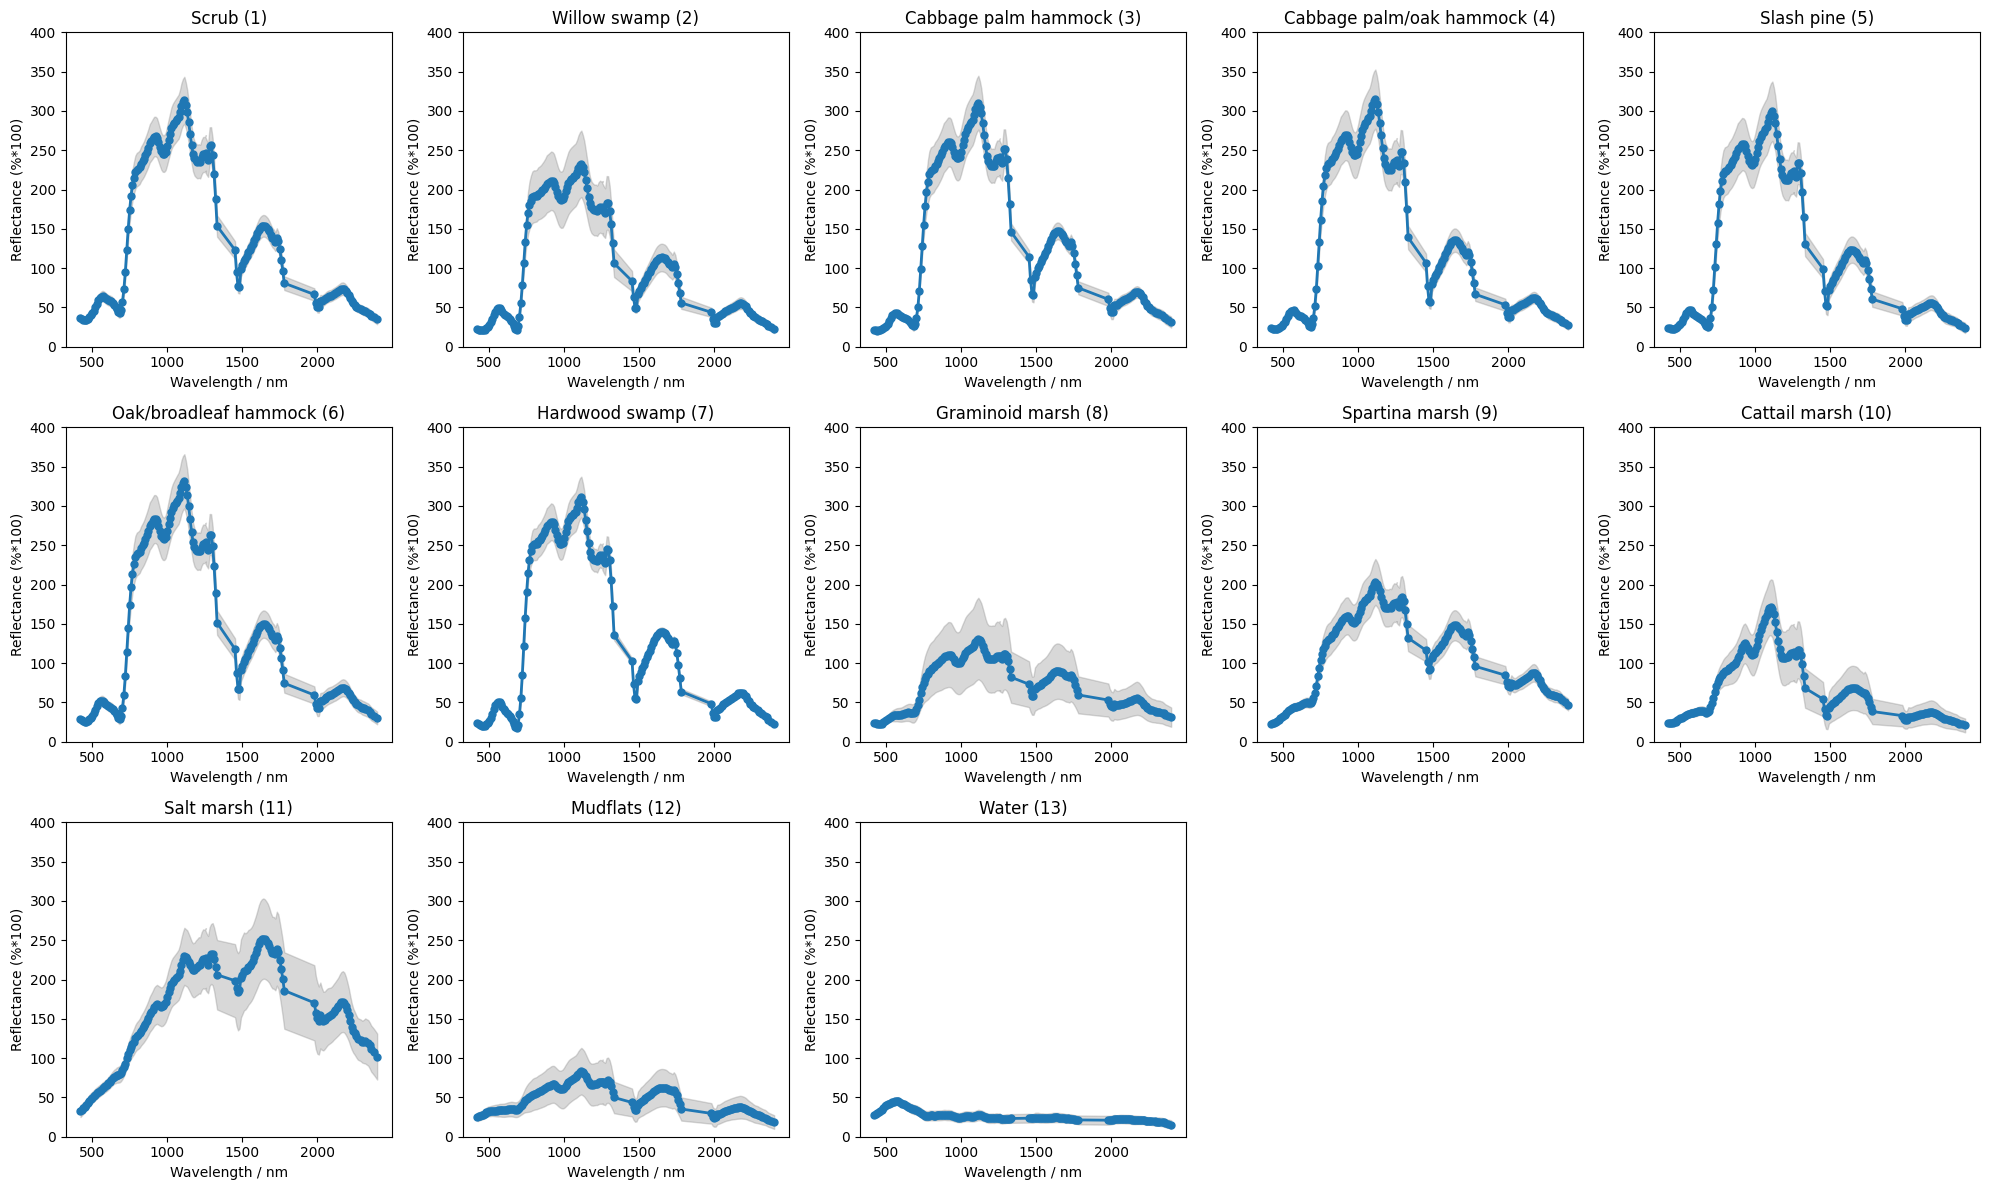

In [12]:
from scipy.signal import savgol_filter


p = 2
n = 11  # should be odd

cal_ref_smooth = savgol_filter(cal_ref, window_length=n, polyorder=p, axis=1)

plot_all_spectras(cal_ref_smooth)

## Random Forest Classification

In [ ]:
import warnings
warnings.filterwarnings('ignore') # small tree sizes in rf do not have oob error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

cal_class_values = np.array(cal_class_values)

rf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)

rf.fit(cal_ref, cal_class_values)

def scoring_rf(randomforest):
    print(f"OOB Score: {randomforest.oob_score_:.4f}") # classifies 86% of the samples when using the out-of-bag samples as a validation set

    # Get OOB predictions
    oob_predictions = randomforest.oob_decision_function_.argmax(axis=1) + 1  # match class labels starting from 1

    conf_matrix = confusion_matrix(cal_class_values, oob_predictions)
    class_report = classification_report(cal_class_values, oob_predictions, target_names=class_names)

    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

scoring_rf(rf)

OOB Score: 0.8600
Confusion Matrix:
[[48  1  0  0  0  1  0  0  0  0  0  0  0]
 [ 0 44  0  1  0  0  4  0  0  1  0  0  0]
 [ 0  0 44  3  0  0  0  1  2  0  0  0  0]
 [ 0  1  4 32  5  7  0  1  0  0  0  0  0]
 [ 1  1  0  6 36  5  0  0  1  0  0  0  0]
 [ 4  0  1  7  1 33  3  0  0  0  1  0  0]
 [ 0  3  0  0  0  0 47  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 43  4  0  0  2  0]
 [ 0  0  0  0  0  0  0  4 46  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  1 46  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  0 48  1  0]
 [ 0  0  0  0  0  0  0  5  0  3  0 42  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50]]

Classification Report:
                              precision    recall  f1-score   support

                   Scrub (1)       0.91      0.96      0.93        50
            Willow swamp (2)       0.88      0.88      0.88        50
    Cabbage palm hammock (3)       0.88      0.88      0.88        50
Cabbage palm/oak hammock (4)       0.65      0.64      0.65        50
              Slash pine (5)       0.86   

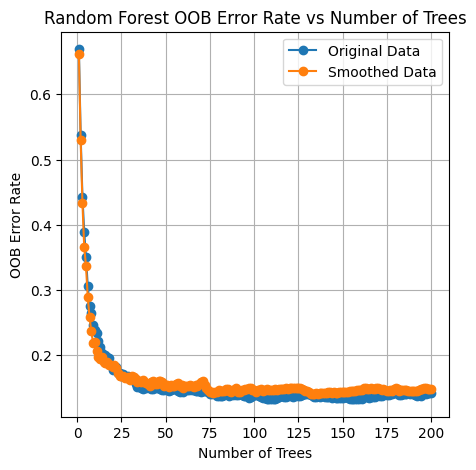

In [14]:
#Plot the oob error (scikit does not come with an easy solution unfortunately; incrementally increasing trees)
rf_warm = RandomForestClassifier(n_estimators=1, warm_start=True, oob_score=True, random_state=42)
rf2_warm = RandomForestClassifier(n_estimators=1, warm_start=True, oob_score=True, random_state=42)

oob_errors1 = []
oob_errors2 = []

# record OOB errors
for i in range(1, 201):
    rf_warm.set_params(n_estimators=i)
    rf_warm.fit(cal_ref, cal_class_values)
    oob_error1 = 1 - rf_warm.oob_score_
    oob_errors1.append(oob_error1)

    rf2_warm.set_params(n_estimators=i)
    rf2_warm.fit(cal_ref_smooth, cal_class_values)
    oob_error2 = 1 - rf2_warm.oob_score_
    oob_errors2.append(oob_error2)

plt.figure(figsize=(5, 5))
plt.plot(range(1, 201), oob_errors1, marker='o', linestyle='-', label='Original Data')
plt.plot(range(1, 201), oob_errors2, marker='o', linestyle='-', label='Smoothed Data')
plt.xlabel('Number of Trees')
plt.ylabel('OOB Error Rate')
plt.title('Random Forest OOB Error Rate vs Number of Trees')
plt.legend()  
plt.grid(True)
plt.show()

### Q3.5 (2 pts) 
Build a second Random Forest model (rfmod2) using the smoothed reflectance data. Compare
the results in terms of overall and class specific errors as well as in the stability of the errors to the first
model. Does the smoothing improve the model performance?

**Answer:** The OOB error vs. number of trees shows a faster decrease for the smoothed data, but around 25 trees the curves intersect and the performance of the original data is better. Smoothing did not significantly improve the overall or class-specific performance of the RF model. There was even a slight decrease in performance. This may be due to the fact that key features can be lost during smoothing.

In [15]:
rf2 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=42)

rf2.fit(cal_ref_smooth, cal_class_values)

scoring_rf(rf2)

OOB Score: 0.8508
Confusion Matrix:
[[46  1  0  0  0  3  0  0  0  0  0  0  0]
 [ 0 43  0  2  0  0  4  0  0  1  0  0  0]
 [ 0  0 42  5  0  0  0  1  2  0  0  0  0]
 [ 0  1  5 31  6  6  0  1  0  0  0  0  0]
 [ 1  1  0  6 36  5  0  0  1  0  0  0  0]
 [ 5  1  1  6  2 31  3  0  0  0  1  0  0]
 [ 0  2  0  0  0  0 48  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 43  4  0  0  2  0]
 [ 0  0  0  0  0  0  0  4 46  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  1 46  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  0 48  1  0]
 [ 0  0  0  0  0  0  0  5  0  2  0 43  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50]]

Classification Report:
                              precision    recall  f1-score   support

                   Scrub (1)       0.88      0.92      0.90        50
            Willow swamp (2)       0.88      0.86      0.87        50
    Cabbage palm hammock (3)       0.86      0.84      0.85        50
Cabbage palm/oak hammock (4)       0.62      0.62      0.62        50
              Slash pine (5)       0.82   

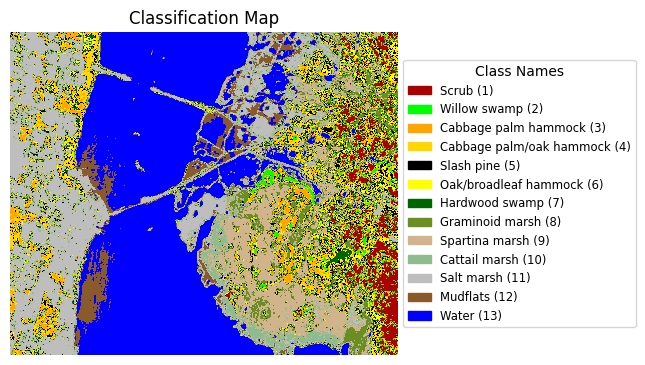

In [16]:
#Classification Map
from matplotlib.colors import ListedColormap


# Reshape (pixels, bands)
n_bands, n_rows, n_cols = image_data.shape
image_data_reshaped = image_data.reshape(n_bands, -1).T

image_data_valid = image_data_reshaped[:, valid_bands]

predictions = rf.predict(image_data_valid)

prediction_map = predictions.reshape(n_rows, n_cols)

cmap = ListedColormap(colors)

plt.figure(figsize=(5, 5))
plt.imshow(prediction_map, cmap=cmap)
plt.title('Classification Map')
plt.axis('off')

plt.legend(handles=legend_handles, loc='center left', fontsize='small', ncol=1, title="Class Names", bbox_to_anchor=(1, 0.5))

plt.show()

# Save as GeoTIFF
crs = image.crs #Coordinate Reference
with rasterio.open(
    f"{path}/rfmap.tif",
    'w',
    driver='GTiff',
    height=n_rows,
    width=n_cols,
    count=1,
    dtype=prediction_map.dtype,
    crs=crs,
    transform=transform,
) as dst:
    dst.write(prediction_map.astype(rasterio.uint8), 1)

### Q3.6 (2 pts)
To which class has the built up area in Titusville been assigned? Can you imagine why the
built up area has been assigned to this particular class?

**Answer:** It was mostly assigned to Salt Marsh. The building area must be assigned to one of the thirteen classes, as we do not have a class like "Other". Vegetation is unlikely to fit because of its different spectra. The other march types are more like dampened vegetation spectra. Water and mudflats also have unique spectral signatures that don't match urban surfaces. Salt marsh had a high standard deviation, so it may have overlapped with spectras of built up area or it was just the closest match.

## Accuracy Assessment

In [ ]:
val_sf = shapefile.Reader(f"{path}/aviris_ksc_gt_valpoints.shp")

val_cols, val_rows, val_x, val_y, val_class_values = extract(val_sf)
val_class = np.array(val_class_values)

print(val_class.shape)

# predicted classes val points
val_predictions = []
for col, row in zip(val_cols, val_rows):
    val_predictions.append(prediction_map[row, col])

cfm = confusion_matrix(val_class, val_predictions, labels=np.unique(val_class))

# reordering not necessary, confusion_matrix returns rows and columns in the order of the labels

print("Confusion Matrix:")
print(cfm)

# sum of diagonal divided through sum of all
oac = round(np.sum(np.diag(cfm)) / np.sum(cfm), 3)
print(f"Overall Accuracy: {oac}")

Shapes [Shape #0: POINT, Shape #1: POINT, Shape #2: POINT, Shape #3: POINT, Shape #4: POINT]
Records [Record #0: [1], Record #1: [1], Record #2: [1], Record #3: [1], Record #4: [1]]
(650,)
Confusion Matrix:
[[47  1  0  2  0  0  0  0  0  0  0  0  0]
 [ 0 46  0  0  0  2  2  0  0  0  0  0  0]
 [ 0  0 44  4  0  0  0  0  2  0  0  0  0]
 [ 0  0  2 37  1  7  1  0  1  1  0  0  0]
 [ 0  0  4 10 35  1  0  0  0  0  0  0  0]
 [ 9  2  2  1  1 32  3  0  0  0  0  0  0]
 [ 0  2  0  2  0  0 46  0  0  0  0  0  0]
 [ 0  1  1  0  1  0  0 36 11  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 48  0  1  0  0]
 [ 0  0  0  0  0  0  0  2  7 39  2  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 49  0  0]
 [ 0  0  0  0  0  0  0  2  0  2  0 44  2]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50]]
Overall Accuracy: 0.851


### Q3.7 (1 pt) 
How large is thus the overall error of the classification? Is this error in line with the OOB error
that is given when you call rfmod (or rfmod2)

**Answer:** Overall Error: 0.149; the OOB-Error 0.140 is almost in line.

In [18]:
overall_error = 1 - oac
print(f"Overall Error: {(1 - oac):.3f}")
print(f"OOB Error: {(1 - rf.oob_score_):.3f}")

Overall Error: 0.149
OOB Error: 0.140


In [ ]:
users_acc = np.round(np.diag(cfm) / np.sum(cfm, axis=1), 2)
users_acc_dict = dict(zip(class_names, users_acc))

print("User's Accuracy (Precision) for each class:")
for class_name, acc in users_acc_dict.items():
    print(f"{class_name}: {acc}")

producers_acc = np.round(np.diag(cfm) / np.sum(cfm, axis=0), 2)
producers_acc_dict = dict(zip(class_names, producers_acc))

print("\nProducer's Accuracy (Recall) for each class:")
for class_name, acc in producers_acc_dict.items():
    print(f"{class_name}: {acc}")

User's Accuracy (Precision) for each class:
Scrub (1): 0.94
Willow swamp (2): 0.92
Cabbage palm hammock (3): 0.88
Cabbage palm/oak hammock (4): 0.74
Slash pine (5): 0.7
Oak/broadleaf hammock (6): 0.64
Hardwood swamp (7): 0.92
Graminoid marsh (8): 0.72
Spartina marsh (9): 0.96
Cattail marsh (10): 0.78
Salt marsh (11): 0.98
Mudflats (12): 0.88
Water (13): 1.0

Producer's Accuracy (Recall) for each class:
Scrub (1): 0.84
Willow swamp (2): 0.88
Cabbage palm hammock (3): 0.83
Cabbage palm/oak hammock (4): 0.66
Slash pine (5): 0.9
Oak/broadleaf hammock (6): 0.76
Hardwood swamp (7): 0.88
Graminoid marsh (8): 0.9
Spartina marsh (9): 0.69
Cattail marsh (10): 0.93
Salt marsh (11): 0.94
Mudflats (12): 1.0
Water (13): 0.96


### Q3.8 (1 pt) 
Which classes show the lowest user's and producer's accuracy and feature thus the largest
error?

**Answer**

Lowest User's Accuracy: Oak/broadleaf hammock 0.64; Slash Pine 0.7; Graminoid Marsh 0.72

Lowest Producer's Accuracy: Cabbage palm/oak hammock 0.66; Spartina marsh 0.69; Oak/broadleaf hammock 0.76

## Importance of spectral bands for the classification

(650, 170)
(650,)


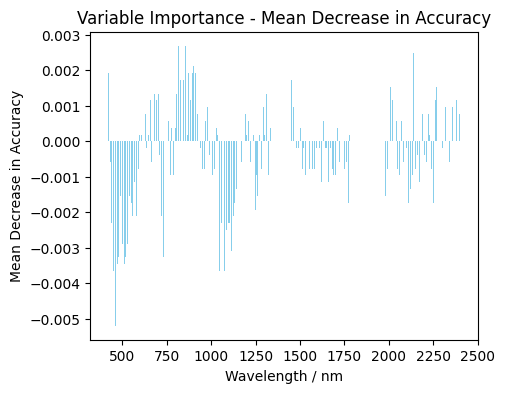

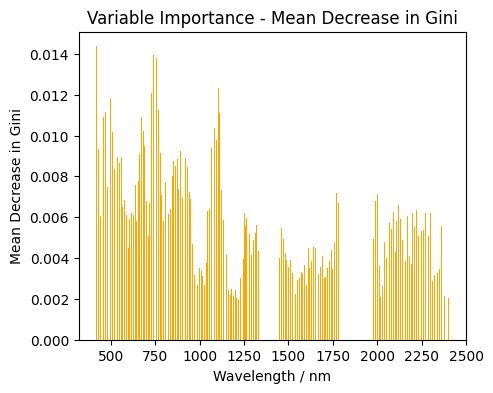

In [20]:
from sklearn.inspection import permutation_importance

# Mean Decrease Gini
importances_gini = rf.feature_importances_

# permutation importance analogeu to Mean Decrease Accuracy
# we will need the val_features
val_features = []
for col, row in zip(val_cols, val_rows):
    pixel_index = row * n_cols + col #n_cols from image_data shape
    val_features.append(image_data_valid[pixel_index])

val_features = np.array(val_features)
# this may take some time to compute
print(val_features.shape)
print(val_class.shape)
result = permutation_importance(rf, val_features, val_class, n_repeats=8, random_state=42) #ive tested it with the training data: this does not work as it overfitted on these points
importances_perm = result.importances_mean


plt.figure(figsize=(5, 4))
plt.bar(wl_filtered, importances_perm, width=5, color='skyblue')
plt.xlabel('Wavelength / nm')
plt.ylabel('Mean Decrease in Accuracy')
plt.title('Variable Importance - Mean Decrease in Accuracy')
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(wl_filtered, importances_gini, width=5, color='orange')
plt.xlabel('Wavelength / nm')
plt.ylabel('Mean Decrease in Gini')
plt.title('Variable Importance - Mean Decrease in Gini')
plt.show()

### Q3.9 (3 pts) 
Which spectral bands/wavelengths contribute most to the classification? Where do the two
metrics agree in their importance assessment, where do they differ? Can you give an explanation for their
importance?

**Answer:**

The first band at 421 nm has high importance in MDG and MDA [Blue: Maybe due to clorophyll absorption, good discriminator between classes]

420-600 nm MDG shows higher importance than MDA.

Higher importance in both metrics around 650-680 nm. [Red: Again clorophyll absorption]

Both show high importance from 750-950 nm, likely due to distinct characteristics of the vegetation spectrums here (reflects strongly in the NIR). And lower importance from 950 to 1050 nm.

From 1050 to 1150 nm MDG shows high importance while MDA shows low importance. [SWIR: Water absorption could be a good discriminator]

From 1450 to 1780 nm and from 2000 to 2400 they both give medium importance to the bands with slight variations.

The top five bands are completely different for both metrics.
MDG focuses more on the splitting power within the decision trees, while MDA focuses on the overall classification performance.

Top Mean Decrease in Accuracy:
Wavelength: 855.05 nm, Importance: 0.002692307692307619
Wavelength: 816.65 nm, Importance: 0.002692307692307605
Wavelength: 2140.9 nm, Importance: 0.002499999999999919
Wavelength: 903.06 nm, Importance: 0.002115384615384547
Wavelength: 912.67 nm, Importance: 0.0019230769230768607

Top Mean Decrease in Gini:
Wavelength: 421.98 nm, Importance: 0.014366565026359782
Wavelength: 739.92 nm, Importance: 0.0139493540379198
Wavelength: 749.51 nm, Importance: 0.013806052181090366
Wavelength: 759.09 nm, Importance: 0.013785553429019765
Wavelength: 1104.8 nm, Importance: 0.012331757157952232


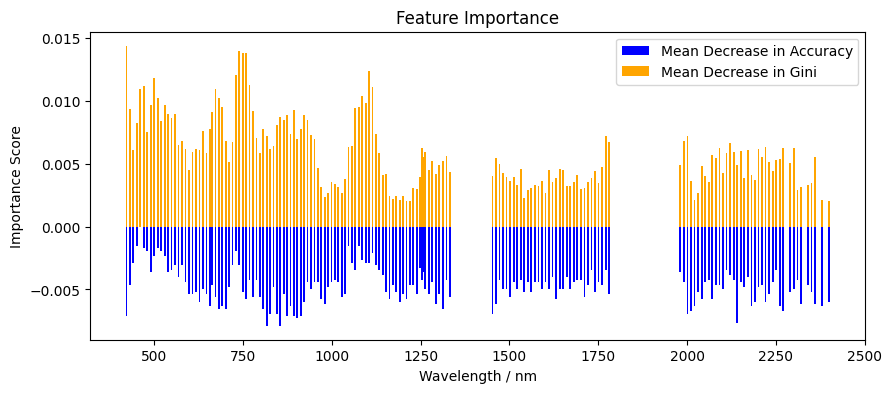

In [ ]:
top_mda_indices = np.argsort(np.array(importances_perm))[-5:][::-1]  
top_mda_wl = np.array(wl_filtered)[top_mda_indices]  
top_mda_scores = importances_perm[top_mda_indices]

print("Top Mean Decrease in Accuracy:")
for i in range(5):
    print(f"Wavelength: {top_mda_wl[i]} nm, Importance: {top_mda_scores[i]}")


top_gini_indices = np.argsort(np.array(importances_gini))[-5:][::-1]  
top_gini_wl = np.array(wl_filtered)[top_gini_indices]     
top_gini_scores = importances_gini[top_gini_indices]

print("\nTop Mean Decrease in Gini:")
for i in range(5):
    print(f"Wavelength: {top_gini_wl[i]} nm, Importance: {top_gini_scores[i]}")

plt.figure(figsize=(10, 4))

#we plot the importance_perm on the negative axis 
plt.bar(wl_filtered, -(importances_perm - np.min(importances_perm)), width=5, color='blue', label='Mean Decrease in Accuracy')
plt.bar(wl_filtered, importances_gini, width=5, color='orange', label='Mean Decrease in Gini')

plt.xlabel('Wavelength / nm')
plt.ylabel('Importance Score')
plt.title('Feature Importance')

plt.legend()
plt.show()

### Q3.10 (4 pts) 
Please read the paper on the Random Forest application case study provided in moodle and
post in the moodle forum one (or more) question(s) that address(es) the paper and its methodology for our
joint discussion.



>   "Despite the general success of the classification results and the
    robustness of the Random Forest approach displayed in this study,
    Random Forest is still considered to be a ‘black-box’ approach due
    mainly to the fact that the user cannot separately analyse and view
    the individual decision trees created in the ‘forest’ and has only a
    small number of settings with which to define or adjust the model
    (Prasad et al., 2006). As a result, implementing the optimal decision
    tree as a classifier in popular remote sensing mapping software
    (e.g. ENVI) would be very challenging for the user wishing to put
    this classification model into practice, for example to produce
    maps over larger image extents. Investigating alternative scripting
    and programming related approaches could circumvent this issue
    but this is beyond the scope of this study." (p.177)

With some additional effort, it might be possible to build an RF model from scratch or modify an existing implementation (e.g., by monkey patching). In this way, it would be possible to implement the optimal decision tree as a classifier (in popular remote sensing mapping software) as mentioned above. Is it practical and useful to modify or rebuild the Random Forest implementation beyond this scope? Which of these points could be achieved and how well? What challenges might arise?

- Visualize the network of individual decision trees for better explainability/interpretability
- Identify causes of classification errors (e.g. spectral confusion) + improve classification accuracy by experimenting with different settings
- Perform more detailed feature analysis and better understand feature interactions and correlations
